# |In this notebook we fit a SEIR model to the Moscow Covid-19 data

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm

In [3]:
sns.set()
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [6]:
from sir_models.seir import SEIR
from sir_models.utils import stepwise

# Load data

In [7]:
df = pd.read_csv('data/moscow_prepared.csv', parse_dates=['date'])

# Model

In [8]:
train_subset = df[(df.date >= '2020-03-25') & (df.date <= '2020-11-30')]

In [9]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

264   2020-12-01
265   2020-12-02
266   2020-12-03
Name: date, dtype: datetime64[ns]

In [10]:
model = SEIR()
model.fit(train_subset)

Getting initial conditions
Optimizing params
Mae: 204.45947595560068
Mae: 204.45947595560068
Mae: 204.45947595560068
Mae: 204.45913742963612
Mae: 204.45934363655
Mae: 204.4594324258969


KeyboardInterrupt: 

In [ ]:
(S, E, I, R, D), history = model.predict_train()

result = model.fit_result_
result

In [ ]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

In [11]:
plt.figure(figsize=(10, 7))
plt.plot(history.new_infected, label='daily infected')
plt.plot(history.new_dead, label='daily deaths')
plt.plot(history.new_recovered, label='daily recovered')
plt.legend()
plt.show()

NameError: name 'history' is not defined

<Figure size 720x504 with 0 Axes>

NameError: name 'R' is not defined

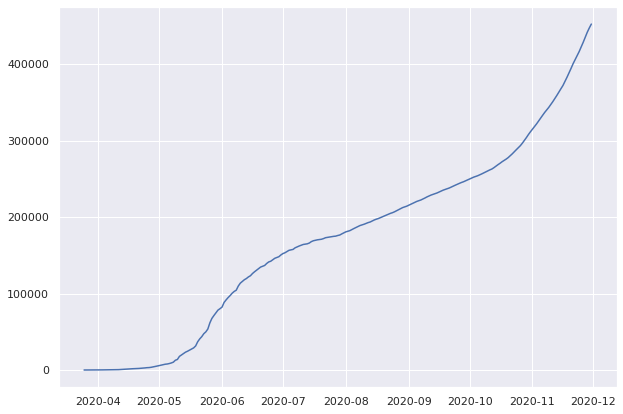

In [12]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

NameError: name 'R' is not defined

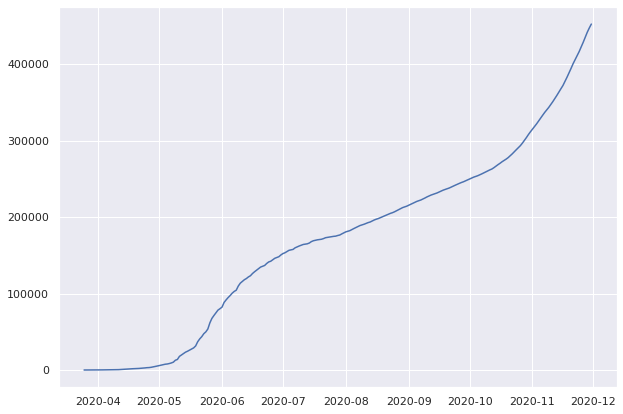

In [13]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_recovered'], label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='ground truth')
plt.plot(train_subset.date, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

NameError: name 'history' is not defined

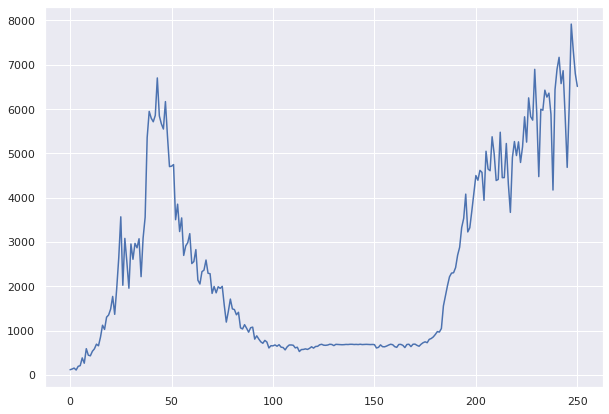

In [14]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_subset)), train_subset['infected_per_day'], label='ground truth')
plt.plot(history.new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

# Obtain forecast

In [15]:
test_t = len(train_subset) + np.arange(len(test_subset))

(test_S, test_E, test_I, test_R, test_D), history = model.predict_test(test_t)

NameError: name 'D' is not defined

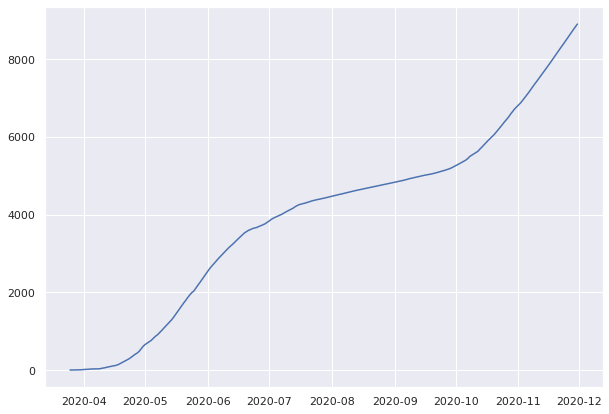

In [16]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Active cases')
plt.show()

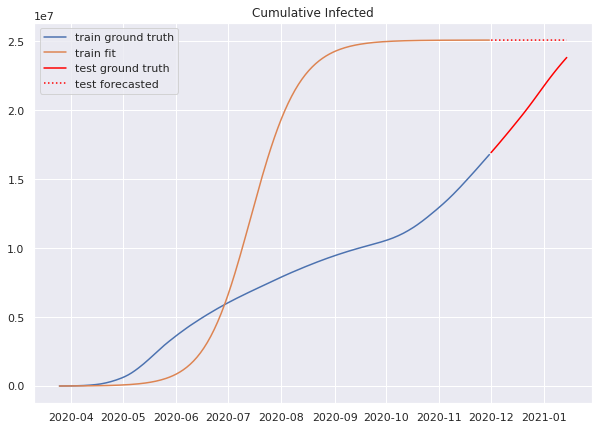

In [26]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected'].sum()+test_subset['infected'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative Infected')
plt.show()

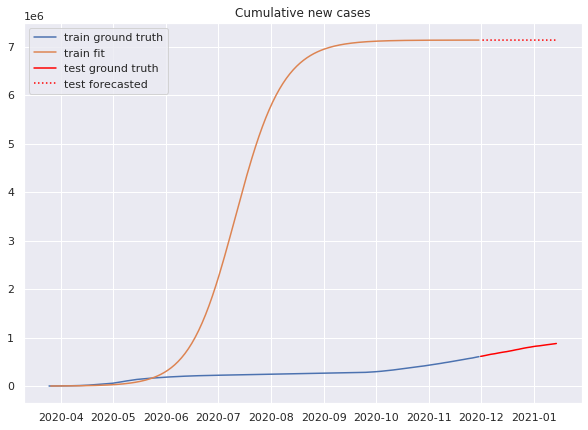

In [27]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected_per_day'].cumsum(), label='train ground truth')
plt.plot(train_subset.date, (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).cumsum(), label='train fit')

plt.plot(test_subset.date, train_subset['infected_per_day'].sum()+test_subset['infected_per_day'].cumsum(), label='test ground truth', color='red')
plt.plot(test_subset.date,  (pd.Series(I).diff() + pd.Series(R).diff() + pd.Series(D).diff()).sum()+(pd.Series(test_I).diff() + pd.Series(test_R).diff() + pd.Series(test_D).diff()).cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Cumulative new cases')
plt.show()

# Future forecast

In [28]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)

future_t = np.arange(test_t[-1], test_t[-1]+len(future_dates))

assert len(future_dates) == len(future_t)

In [29]:
test_future_t = np.concatenate([test_t, future_t])

In [30]:
(future_S, future_E, future_I, future_R, future_D), history = model.predict_test(test_future_t)

future_S, future_E, future_I, future_R, future_D = future_S[len(test_t):], future_E[len(test_t):], future_I[len(test_t):], future_R[len(test_t):], future_D[len(test_t):]

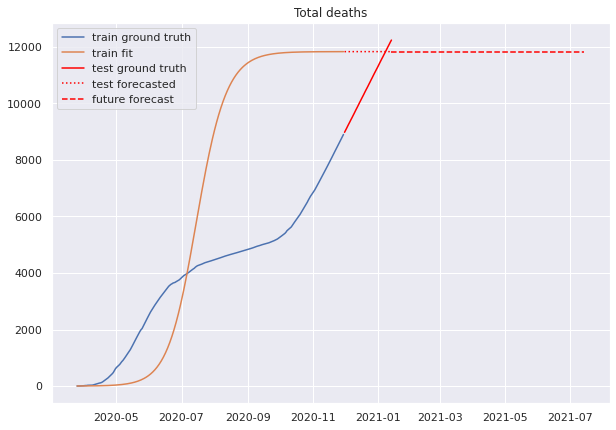

In [31]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_dead'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_dead'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_D, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Total deaths')
plt.show()

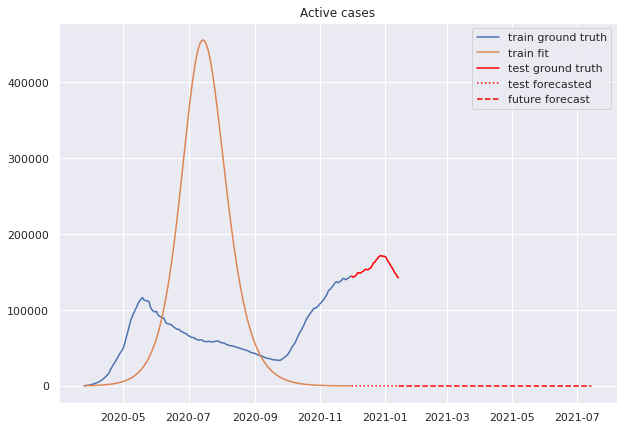

In [32]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['infected'], label='train ground truth')
plt.plot(train_subset.date, I, label='train fit')

plt.plot(test_subset.date, test_subset['infected'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_I, label='test forecasted', color='red', linestyle=':')

plt.plot(future_dates, future_I, label='future forecast', color='red', linestyle='--')
plt.legend()
plt.title('Active cases')
plt.show()

# 1-day ahead evaluate

In [33]:
from sklearn.metrics import mean_absolute_error

In [34]:
n_eval_points = 10
eval_period_start = '2020-05-01'
eval_df = df[df.date >= eval_period_start].sample(n_eval_points)
pred_dates = []

true_D, true_R = [], []

baseline_pred_D, baseline_pred_R = [], []
model_pred_D, model_pred_R = [], []

for row in tqdm(eval_df.itertuples(), total=len(eval_df)):
    true_D.append(row.total_dead)
    true_R.append(row.total_recovered)
    
    train_df = df.iloc[:row.Index]
    
    pred_dates.append(row.date)
    prev_day = train_df.iloc[-1]
    pred_D = prev_day.total_dead
    pred_R = prev_day.total_recovered
    baseline_pred_D.append(pred_D)
    baseline_pred_R.append(pred_R)
    
    model = SEIR(verbose=False)
    model.fit(train_df)

    (S, E, I, R, D), history = model.predict_test([len(train_df)])
    model_pred_D.append(D[0])
    model_pred_R.append(R[0])



Mae: 180.09506316663752
Mae: 180.09506316663752
Mae: 180.09506316663752
Mae: 180.09477232745863
Mae: 180.09495567889377
Mae: 180.09502589839818
Mae: 180.0950566802446
Mae: 185.29399535151384
Mae: 180.35476331882785
Mae: 181.39684104685355
Mae: 188.20384088309456
Mae: 185.2449959059773
Mae: 177.86192670465508
Mae: 177.86192560982948
Mae: 177.86191139029737
Mae: 177.86193548408
Mae: 177.8619242782355
Mae: 176.6264317687304
Mae: 176.62643794788568
Mae: 176.62631859244755
Mae: 176.62633722334394
Mae: 176.6264293221491
Mae: 176.0378275013231
Mae: 176.03782665376715
Mae: 176.03772235939985
Mae: 176.0378304618008
Mae: 176.03782504880695
Mae: 175.68258896339478
Mae: 175.68258409885178
Mae: 175.6825660693078
Mae: 175.68259637846145
Mae: 175.68258650733128
Mae: 185.50927090220543
Mae: 175.64363944556015
Mae: 175.64364467097144
Mae: 175.64366029537646
Mae: 175.64365015953604
Mae: 175.64363698849598
Mae: 175.60699239482992
Mae: 175.60700247368624
Mae: 175.6069734480352
Mae: 175.60701483171084
Mae:

KeyboardInterrupt: 

In [35]:
baseline_D_mae = mean_absolute_error(true_D, baseline_pred_D)
baseline_R_mae = mean_absolute_error(true_R, baseline_pred_R)

model_D_mae = mean_absolute_error(true_D, model_pred_D)
model_R_mae = mean_absolute_error(true_R, model_pred_R)

print('Baseline D mae', round(baseline_D_mae, 3))
print('Model D mae', round(model_D_mae, 3))

print('Baseline R mae', round(baseline_R_mae, 3))
print('Model R mae', round(model_R_mae, 3))

ValueError: Found input variables with inconsistent numbers of samples: [5, 4]